# Procesamiento y Limpieza SECOP I

En este notebook de código se desarrollan los códigos para procesar, limpiar y calcular indicadores de riesgo y banderas rojas en contratación pública a partir de los datos abiertos del SECOP I.

In [64]:
# Cargar librerias para limpieza y procesamiento de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
pd.set_option('display.max_columns', None)

In [65]:
# Cargar datos de compras y suministros
suministro = pd.read_csv("Datos/div_secop_i_Suministro.gz")
compraventa = pd.read_csv("Datos/div_secop_i_Compraventa.gz")
compras = pd.concat([suministro,compraventa], axis=0)
del [compraventa, suministro]
compras.head()

In [ ]:
# Extraer información general de la base de datos de contratos de compra
compras.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1265987 entries, 0 to 351052
Data columns (total 44 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   id_contrato                       1265987 non-null  object 
 1   anno_cargue                       1265987 non-null  int64  
 2   anno_firma                        1265987 non-null  float64
 3   nivel_entidad                     1265987 non-null  object 
 4   orden_entidad                     1265987 non-null  object 
 5   nombre_entidad                    1265987 non-null  object 
 6   nit_entidad                       1265987 non-null  object 
 7   tipo_proceso                      1265987 non-null  object 
 8   estado_contrato                   1265987 non-null  object 
 9   causa_otras_formas_contr_directa  1265987 non-null  object 
 10  regimen_contratacion              1265987 non-null  object 
 11  objeto_contratar                  1265

# Limpieza, Procesamiento y Filtrado de datos

A continuación se describen algunas tareas pendientes de limpieza de datos.

* [ ] Corregir los valores extremos y contratos de valor cero. Utilizar los algoritmos y datos de la consultoría DAPRE.
* [ ] Limpiear el nit de los contratistas y las entidades.
* [X] Estandarizar algunas variables como tipo de proceso, nivel y orden de la entidad, entre otros.
* [X] Unificar la duración del contrato.
* [X] Revisar y ajustar contratos con valor en dolares.
* [ ] Agregar variables de minima cuantia y menor cuantia para cada entidad

## Filtro de Contratos por cuantía

Se aplica el siguiente filtro:

- Contratos de mas de 100 millones.
- Entidades con mínimo 5 contratos.

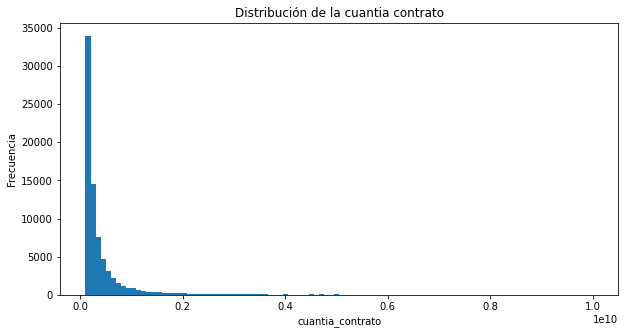

In [ ]:
# Histogram for cuantia_contrato
plt.figure(figsize=(10,5))
plt.hist(compras.loc[(compras['cuantia_contrato'] > 1e8) & (compras['cuantia_contrato'] < 1e10), ['cuantia_contrato']], bins=100)
plt.title('Distribución de la cuantia contrato')
plt.xlabel('cuantia_contrato')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# Número de contratos por menos de 100 millones
sum(compras['cuantia_contrato'] < 1e8)

1185404

In [ ]:
# Número de contratos por mas de 100 mil millones
sum(compras['cuantia_proceso'] > 1e11)

232

In [ ]:
# Seleccionar contratos de una cuantia mínima
min_valor = 1e8 # Mas de 100 millones
max_valor = 1e11 # Menos de 100,000 millones
compras = compras.loc[((compras["cuantia_contrato"] >= min_valor) | 
                       (compras["cuantia_proceso"] >= min_valor) | 
                       (compras["valor_adiciones"] >= min_valor)) 
                      & (compras["cuantia_contrato"] <= max_valor)]
print("Hay {:,} contratos de mínimo ${:,.0f} y de máximo ${:,.0f}".format(compras.shape[0], min_valor, max_valor))

Hay 94,910 contratos de mínimo $100,000,000 y de máximo $100,000,000,000


## Filtrado de entidades por número mínimo de contratos

In [ ]:
# Incluir entidades con mínimo 5 contratos
min_contratos = 5
temp = compras.groupby('nombre_entidad').size().reset_index().rename({0:'n_contratos'}, axis=1)
temp = temp.loc[temp['n_contratos'] >= min_contratos]
print("Hay {} entidades con mínimo {} contratos".format(temp.shape[0], min_contratos))

# Filtrar entidades con la minima cantidad de contratos requeridas
compras = compras.loc[compras["nombre_entidad"].isin(temp["nombre_entidad"])]
del temp

Hay 1767 entidades con mínimo 5 contratos


In [ ]:
print('Filtrando entidades con mínimo {} contratos nos quedan {:,.0f} registros'.format(min_contratos, compras.shape[0]))

Filtrando entidades con mínimo 5 contratos nos quedan 92,897 registros


## Estandarización del tipo de proceso

In [ ]:
# Tipo de proceso
compras.value_counts(['tipo_proceso'])

tipo_proceso                                                                         
Subasta                                                                                  29554
Régimen Especial                                                                         29533
Selección Abreviada de Menor Cuantía (Ley 1150 de 2007)                                  16044
Contratación Directa (Ley 1150 de 2007)                                                   9020
Licitación Pública                                                                        7448
Contratación Mínima Cuantía                                                                937
Selección Abreviada del literal h del numeral 2 del artículo 2 de la Ley 1150 de 2007      152
Selección Abreviada servicios de Salud                                                     125
Licitación obra pública                                                                     46
Contratos y convenios con más de dos partes                

In [ ]:
# Estandarización del tipo de proceso
map_tipo_proceso = {
    "Concurso de Méritos Abierto": "concurso_meritos", 
    "Concurso de Méritos con Lista Corta": "concurso_meritos", 
    "Concurso de Méritos con Lista Multiusos": "concurso_meritos",
    "Contratación Directa (Ley 1150 de 2007)":"contratacion_directa",
    "Contratación Directa (con ofertas)":"contratacion_directa",
    "Contratación directa":"contratacion_directa",
    "Contratación Mínima Cuantía":"minima_cuantia",
    "Mínima cuantía":"minima_cuantia",
    "Licitación Pública":"licitacion_publica",
    "Licitación obra pública":"licitacion_publica", 
    "Licitación pública":"licitacion_publica",
    "Régimen Especial":"regimen_especial",
    "Contratación régimen especial":"regimen_especial",
    "Contratación régimen especial (con ofertas)":"regimen_especial",
    "Selección Abreviada de Menor Cuantía (Ley 1150 de 2007)":"seleccion_abreviada",
    "Selección Abreviada del literal h del numeral 2 del artículo 2 de la Ley 1150 de 2007":"seleccion_abreviada",
    "Selección Abreviada servicios de Salud":"seleccion_abreviada",
    "Seleccion Abreviada Menor Cuantia Sin Manifestacion Interes":"seleccion_abreviada",
    "Selección Abreviada de Menor Cuantía":"seleccion_abreviada",
    "Selección abreviada subasta inversa":"seleccion_abreviada",
    "Subasta":"subasta",
    "Contratos y convenios con más de dos partes":"otros",
    "Asociación Público Privada":"otros"
}
compras["tipo_proceso"].replace(to_replace=map_tipo_proceso, inplace=True)
compras.groupby("tipo_proceso").size().sort_values(ascending=False)

tipo_proceso
subasta                 29554
regimen_especial        29533
seleccion_abreviada     16321
contratacion_directa     9020
licitacion_publica       7494
minima_cuantia            937
concurso_meritos           19
otros                      19
dtype: int64

## Estadarización del nivel de entidad

In [ ]:
# Estandarización para el nivel de la entidad
map_nivel_entidad = {
    "NACIONAL":"nacional",
    "TERRITORIAL":"territorial",
    "No Definida":"no_definida"
}
compras["nivel_entidad"].replace(to_replace=map_nivel_entidad, inplace=True)
compras.groupby("nivel_entidad").size().sort_values(ascending=False)

nivel_entidad
territorial    57001
nacional       35896
dtype: int64

In [ ]:
# Verificar si la entidad tiene registrado mas de un nivel
print("Hay {} entidades con mas de un nivel de entidad registrado".format(sum(compras.groupby("nombre_entidad")["nivel_entidad"].nunique() > 1)))

Hay 0 entidades con mas de un nivel de entidad registrado


## Estadarización de las categorías para el orden de la entidad

In [ ]:
# Redefinir las categorias para el orden de entidad
map_orden_entidad = {
    "DISTRITO CAPITAL": "distr_capital",
    "NACIONAL CENTRALIZADO": "nac_centralizado",
    "NACIONAL DESCENTRALIZADO":"nac_descentralizado",
    "TERRITORIAL DEPARTAMENTAL CENTRALIZADO": "terri_dep_centr",
    "TERRITORIAL DEPARTAMENTAL DESCENTRALIZADO": "terri_dep_no_centr",
    "TERRITORIAL DISTRITAL MUNICIPAL NIVEL 1": "terri_distr_1",
    "TERRITORIAL DISTRITAL MUNICIPAL NIVEL 2": "terri_distr_2",
    "TERRITORIAL DISTRITAL MUNICIPAL NIVEL 3": "terri_distr_3",
    "TERRITORIAL DISTRITAL MUNICIPAL NIVEL 4": "terri_distr_4",
    "TERRITORIAL DISTRITAL MUNICIPAL NIVEL 5": "terri_distr_5",
    "TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6": "terri_distr_6",
    "No Definido": "no_defindo"
}

compras["orden_entidad"].replace(to_replace=map_orden_entidad, inplace=True)
print(compras.groupby("orden_entidad").size().sort_values(ascending=False))

# Verificar si la entidad tiene registrado mas de un orden de entidad
print("Hay {} entidades con mas de un orden de entidad registrado".format(sum(compras.groupby("nombre_entidad")["orden_entidad"].nunique() > 1)))

orden_entidad
nac_centralizado       21146
terri_dep_no_centr     18240
nac_descentralizado    15037
terri_distr_6          10433
terri_distr_2           6890
terri_dep_centr         6570
terri_distr_1           6480
distr_capital           2645
terri_distr_4           2560
terri_distr_5           1930
terri_distr_3            966
dtype: int64
Hay 0 entidades con mas de un orden de entidad registrado


In [63]:
# Asignar orden de entidad con mayor frecuencia
# Activar procesamiento de orden de entidad
asignar_orden = False
if asignar_orden:
    temp = compras.groupby("nombre_entidad")["orden_entidad"].nunique()
    temp = temp[temp > 1]
    temp2 = compras.loc[compras["nombre_entidad"].isin(temp.index)].groupby(["nombre_entidad","orden_entidad"]).size().reset_index().rename({0:"n"}, axis=1)

    def sel_orden(groups):
        n_orden = groups.sort_values(by = "n", ascending = False)
        orden = n_orden["orden_entidad"][0:1]
        return orden

    temp3 = temp2.groupby("nombre_entidad").apply(sel_orden).reset_index()

    for i in range(temp3.shape[0]):
        compras.loc[compras["nombre_entidad"] == temp3["nombre_entidad"][i], ["orden_entidad"]] = temp3["orden_entidad"][i]
        
    del [temp, temp2, temp3]

    # Verificar si la entidad tiene registrado mas de un nivel
    print("Hay {} entidades con mas de un orden de entidad registrado".format(sum(compras.groupby("nombre_entidad")["nivel_entidad"].nunique() > 1)))


In [57]:
temp2 = compras.loc[compras["nombre_entidad"].isin(temp.index)]
temp2.sort_values(by=['nombre_entidad','anno_firma'], ascending=True)

,id_contrato,anno_cargue,anno_firma,nivel_entidad,orden_entidad,nombre_entidad,nit_entidad,tipo_proceso,estado_contrato,causa_otras_formas_contr_directa,regimen_contratacion,objeto_contratar,detalle_objeto_contratar,tipo_contrato,fecha_cargue_secop,id_proceso,numero_proceso,numero_contrato,cuantia_proceso,nombre_grupo,nombre_familia,nombre_clase,tipo_id_contratista,id_contratista,razon_social_contratista,dpto_mcpo_contratista,tipo_doc_representate_legal,id_representante_legal,nombre_representante_legal,fecha_firma_contrato,fecha_inicio_ejec_contrato,plazo_ejec_contrato,rango_ejec_contrato,tiempo_adiciones_dias,tiempo_adiciones_meses,fecha_fin_ejec_contrato,cuantia_contrato,valor_adiciones,ruta_web,moneda,municipio_entidad,departamento_entidad,dep_codigo_divipola,municipio_codigo_divipola
679633,11-11-530206-573664,2011,2011.0,territorial,terri_distr_6,BOLÍVAR - ALCALDÍA MUNICIPIO DE TURBACO,800099152-9,seleccion_abreviada,Celebrado,Ninguna,Estatuto General de Contratación,"Materiales Combustibles, Aditivos para Combust...",suministro de combustibles y lubricantes que s...,Suministro,07/05/2011,11-11-530206,SA-002-2011,001,108400000,[B] Materias Primas,No Definido,No Definido,Cédula de Ciudadanía,9.046.113,JORGE GHISAYS R E HIJOS LTDA,Bolívar,Cédula de Ciudadanía,9.046.113,JORGE GHISAYS RUJANA,07/23/2011,07/22/2011,7,M,0,0,02/22/2012,108400000,0,https://www.contratos.gov.co/consultas/detalle...,Pesos (COP),TURBACO,BOLÍVAR,13000,13836
646785,13-11-1569321-1526206,2013,2013.0,territorial,terri_distr_6,BOLÍVAR - ALCALDÍA MUNICIPIO DE TURBACO,800099152-9,seleccion_abreviada,Celebrado,Ninguna,Estatuto General de Contratación,"Servicios de Minería, Petróleo y Gas",¿suministro de gasolina y lubricantes para el ...,Suministro,04/02/2013,13-11-1569321,SA-MC-001 de 2013,SAMC - 001- 2013,100000000,[F] Servicios,No Definido,No Definido,Nit de Persona Natural,8.834.058,ESTACION PLAN PAREJO TURBACO S.A,Bolívar,Cédula de Ciudadanía,8.834.058,CARLOS ENRIQUE MARTÍNEZ GOMEZ,04/25/2013,04/25/2013,9,M,0,0,01/25/2014,100000000,0,https://www.contratos.gov.co/consultas/detalle...,Pesos (COP),TURBACO,BOLÍVAR,13000,13836
380350,16-9-420428-5802218,2016,2016.0,territorial,terri_distr_5,BOLÍVAR - ALCALDÍA MUNICIPIO DE TURBACO,8901481149-0,subasta,Liquidado,Ninguna,Estatuto General de Contratación,Componentes y Suministros de Manufactura,¿adquisicion de mil (1000) sillas plasticas co...,Suministro,09/16/2016,16-9-420428,SENCIAL-SI-TUR-004-2016,SENCIAL-SI-TUR-004-2016,150000000,[D] Componentes y Suministros,Piezas fundidas maquinadas,Piezas fundidas mecanizadas de proceso v,Nit de Persona Jurídica,900262587,FUNTECOL,Bolívar,Cédula de Ciudadanía,26040910,MARTHA ELENA LOPEZ ACOSTA,10/19/2016,10/19/2017,15,D,0,0,11/03/2017,150000000,0,https://www.contratos.gov.co/consultas/detalle...,Pesos (COP),TURBACO,BOLÍVAR,13000,13836
486928,16-11-5766997-5656032,2016,2016.0,territorial,terri_distr_5,BOLÍVAR - ALCALDÍA MUNICIPIO DE TURBACO,8901481149-0,seleccion_abreviada,Liquidado,Ninguna,Estatuto General de Contratación,"Componentes, Accesorios y Suministros de Siste...",¿suministro e instalacion a todo costo de las ...,Suministro,11/03/2016,16-11-5766997,SA-MC- 0010- 2016-TUR,SA-MC- 0010- 2016-TUR,100000000,[D] Componentes y Suministros,"Equipos, suministros y componentes eléctricos",Relés eléctricos y accesorios,Nit de Persona Jurídica,900715889,TURMAC CONSTRUCCIONES Y ASESORIAS SAS,Bolívar,Cédula de Ciudadanía,1050969634,ERICK MANUEL ESPINOSA BUELVAS,12/06/2016,12/05/2016,15,D,0,0,12/20/2016,100000000,0,https://www.contratos.gov.co/consultas/detalle...,Pesos (COP),TURBACO,BOLÍVAR,13000,13836
248965,17-9-436271-6600388,2017,2017.0,territorial,terri_distr_6,BOLÍVAR - ALCALDÍA MUNICIPIO DE TURBACO,800099152-9,subasta,Liquidado,Ninguna,Estatuto General de Contratación,"Muebles, Mobiliario y Decoración",suministro de mobiliario educativo para las i...,Suministro,10/02/2017,17-9-436271,SENCIAL-SI-TUR-001-2017,SENCIAL-SI-TUR-001-2017,163000000,[E] Productos de Uso Final,"